This notebook provides a minimal working example of the image-to-painting translation and style transfer in the preprint paper "Stylized Neural Painting, arXiv:2011.08114."

[Project Page](https://jiupinjia.github.io/neuralpainter/) | [GitHub](https://github.com/jiupinjia/stylized-neural-painting) | [Preprint](https://arxiv.org/abs/2011.08114)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">   The project </a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [ ]:
# Clone the repository
!git clone https://github.com/jiupinjia/stylized-neural-painting

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 140 (delta 24), reused 1 (delta 0), pack-reused 93
Receiving objects: 100% (140/140), 3.63 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
cd stylized-neural-painting

/content/stylized-neural-painting


In [ ]:
import argparse

import torch
torch.cuda.current_device()
import torch.optim as optim

from painter import *
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# settings
parser = argparse.ArgumentParser(description='STYLIZED NEURAL PAINTING')
args = parser.parse_args(args=[])
args.img_path = './test_images/sunflowers.jpg' # path to input photo
args.renderer = 'oilpaintbrush' # [watercolor, markerpen, oilpaintbrush, rectangle]
args.canvas_color = 'black' # [black, white]
args.canvas_size = 512 # size of the canvas for stroke rendering'
args.keep_aspect_ratio = False # whether to keep input aspect ratio when saving outputs
args.max_m_strokes = 500 # max number of strokes
args.m_grid = 5 # divide an image to m_grid x m_grid patches
args.beta_L1 = 1.0 # weight for L1 loss
args.with_ot_loss = False # set True for imporving the convergence by using optimal transportation loss, but will slow-down the speed
args.beta_ot = 0.1 # weight for optimal transportation loss
args.net_G = 'zou-fusion-net' # renderer architecture
args.renderer_checkpoint_dir = './checkpoints_G_oilpaintbrush' # dir to load the pretrained neu-renderer
args.lr = 0.005 # learning rate for stroke searching
args.output_dir = './output' # dir to save painting results
args.disable_preview = True # disable cv2.imshow, for running remotely without x-display

Download pretrained neural renderer.

In [ ]:
# Define some helper functions for downloading pretrained model
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# download and unzip...
file_id = '1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG'
destination = './checkpoints_G_oilpaintbrush.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip checkpoints_G_oilpaintbrush.zip

Archive:  checkpoints_G_oilpaintbrush.zip
   creating: checkpoints_G_oilpaintbrush/
  inflating: checkpoints_G_oilpaintbrush/last_ckpt.pt  


Define the optimization loop the painter

In [ ]:
def optimize_x(pt):

    pt._load_checkpoint()
    pt.net_G.eval()

    pt.initialize_params()
    pt.x_ctt.requires_grad = True
    pt.x_color.requires_grad = True
    pt.x_alpha.requires_grad = True
    utils.set_requires_grad(pt.net_G, False)

    pt.optimizer_x = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr)

    print('begin to draw...')
    pt.step_id = 0
    for pt.anchor_id in range(0, pt.m_strokes_per_block):
        pt.stroke_sampler(pt.anchor_id)
        iters_per_stroke = int(500 / pt.m_strokes_per_block)
        for i in range(iters_per_stroke):

            pt.optimizer_x.zero_grad()

            pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
            pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
            pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

            if args.canvas_color == 'white':
                pt.G_pred_canvas = torch.ones(
                    [args.m_grid ** 2, 3, pt.net_G.out_size, pt.net_G.out_size]).to(device)
            else:
                pt.G_pred_canvas = torch.zeros(
                    [args.m_grid ** 2, 3, pt.net_G.out_size, pt.net_G.out_size]).to(device)

            pt._forward_pass()
            pt._drawing_step_states()
            pt._backward_x()
            pt.optimizer_x.step()

            pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
            pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
            pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

            pt.step_id += 1

    v = pt.x.detach().cpu().numpy()
    pt._save_stroke_params(v)
    v_n = pt._normalize_strokes(pt.x)
    v_n = pt._shuffle_strokes_and_reshape(v_n)
    final_rendered_image = pt._render(v_n, save_jpgs=False, save_video=True)
    
    return final_rendered_image

Now you can process your image (this will typically take a few minutes)

In [ ]:
  pt = Painter(args=args)
  final_rendered_image = optimize_x(pt)

initialize network with normal
loading renderer from pre-trained checkpoint...
begin to draw...
iteration step 0, G_loss: 0.00000, step_psnr: 5.75066, strokes: 25 / 500
iteration step 1, G_loss: 0.44137, step_psnr: 5.86038, strokes: 25 / 500
iteration step 2, G_loss: 0.43346, step_psnr: 5.96910, strokes: 25 / 500
iteration step 3, G_loss: 0.42515, step_psnr: 6.06110, strokes: 25 / 500
iteration step 4, G_loss: 0.41839, step_psnr: 6.16015, strokes: 25 / 500
iteration step 5, G_loss: 0.41139, step_psnr: 6.25239, strokes: 25 / 500
iteration step 6, G_loss: 0.40500, step_psnr: 6.33209, strokes: 25 / 500
iteration step 7, G_loss: 0.39924, step_psnr: 6.40756, strokes: 25 / 500
iteration step 8, G_loss: 0.39387, step_psnr: 6.48266, strokes: 25 / 500
iteration step 9, G_loss: 0.38847, step_psnr: 6.55463, strokes: 25 / 500
iteration step 10, G_loss: 0.38359, step_psnr: 6.62916, strokes: 25 / 500
iteration step 11, G_loss: 0.37854, step_psnr: 6.69854, strokes: 25 / 500
iteration step 12, G_loss:

Check out your animated results at args.output_dir. Before you download that folder, let's first have a look at what the generated painting looks like.

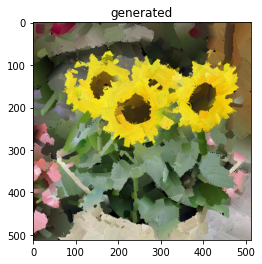

In [ ]:
plt.imshow(final_rendered_image), plt.title('generated')
plt.show()

Next, let's play style-transfer. Since we frame our stroke prediction under a parameter searching paradigm, our method naturally fits the neural style transfer framework.

In [ ]:
# settings
args.content_img_path = './test_images/sunflowers.jpg' # path to content image (i.e., your original input photo)
args.style_img_path = './style_images/picasso.jpg' # path to style image
args.vector_file = './output/sunflowers_strokes.npz' # path to pre-generated stroke vector file 
args.transfer_mode = 1 # style transfer mode, 0: transfer color only, 1: transfer both color and texture
args.beta_L1 = 1.0 # weight for L1 loss
args.beta_sty = 0.5 # weight for vgg style loss
args.net_G = 'zou-fusion-net' # renderer architecture
args.renderer_checkpoint_dir = './checkpoints_G_oilpaintbrush' # dir to load the pretrained neu-renderer
args.lr = 0.005 # learning rate for stroke searching
args.output_dir = './output' # dir to save style transfer results
args.disable_preview = True # disable cv2.imshow, for running remotely without x-display

Define the optimization loop.

In [ ]:
def optimize_x(pt):

    pt._load_checkpoint()
    pt.net_G.eval()

    if args.transfer_mode == 0: # transfer color only
        pt.x_ctt.requires_grad = False
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = False
    else: # transfer both color and texture
        pt.x_ctt.requires_grad = True
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = True

    pt.optimizer_x_sty = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr)

    iters_per_stroke = 100
    for i in range(iters_per_stroke):
        pt.optimizer_x_sty.zero_grad()

        pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
        pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
        pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

        if args.canvas_color == 'white':
            pt.G_pred_canvas = torch.ones([pt.m_grid*pt.m_grid, 3, pt.net_G.out_size, pt.net_G.out_size]).to(device)
        else:
            pt.G_pred_canvas = torch.zeros(pt.m_grid*pt.m_grid, 3, pt.net_G.out_size, pt.net_G.out_size).to(device)

        pt._forward_pass()
        pt._style_transfer_step_states()
        pt._backward_x_sty()
        pt.optimizer_x_sty.step()

        pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
        pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
        pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

        pt.step_id += 1

    print('saving style transfer result...')
    v_n = pt._normalize_strokes(pt.x)
    v_n = pt._shuffle_strokes_and_reshape(v_n)
    final_rendered_image = pt._render(v_n, save_jpgs=False, save_video=False)
    pt._save_style_transfer_images(final_rendered_image)

    return final_rendered_image

You can run style transfer now.

In [ ]:
pt = NeuralStyleTransfer(args=args)
final_rendered_image = optimize_x(pt)

initialize network with normal


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



loading pre-generated vector file...
loading renderer from pre-trained checkpoint...
running style transfer... iteration step 0, G_loss: 0.00000, step_psnr: 23.76187
running style transfer... iteration step 1, G_loss: 3.81428, step_psnr: 14.99639
running style transfer... iteration step 2, G_loss: 2.54901, step_psnr: 14.81966
running style transfer... iteration step 3, G_loss: 1.87393, step_psnr: 14.27905
running style transfer... iteration step 4, G_loss: 1.57168, step_psnr: 14.16640
running style transfer... iteration step 5, G_loss: 1.40042, step_psnr: 13.63089
running style transfer... iteration step 6, G_loss: 1.24606, step_psnr: 13.73926
running style transfer... iteration step 7, G_loss: 1.15543, step_psnr: 13.39792
running style transfer... iteration step 8, G_loss: 1.02196, step_psnr: 13.52208
running style transfer... iteration step 9, G_loss: 0.95994, step_psnr: 13.32215
running style transfer... iteration step 10, G_loss: 0.88025, step_psnr: 13.41544
running style transfer

The high-resoltion style transfer results are available at args.output_dir.

Let's have a prview of the style transfer results.

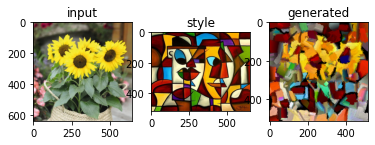

In [ ]:
plt.subplot(1,3,1)
plt.imshow(pt.img_), plt.title('input')
plt.subplot(1,3,2)
plt.imshow(pt.style_img_), plt.title('style')
plt.subplot(1,3,3)
plt.imshow(final_rendered_image), plt.title('generated')
plt.show()